<a href="https://colab.research.google.com/github/94jjiisu/Data-analysis/blob/master/bead_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U pandas-profiling
#!pip install eli5

In [12]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport


from sklearn.model_selection import train_test_split, validation_curve, RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

import graphviz

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, LabelEncoder

from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier


from sklearn.decomposition import PCA

# KNN, 다층퍼셉트론, SVM
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
filename = "/content/drive/MyDrive/DS_camp/session2/Dry_Bean_Dataset.xlsx"

df = pd.read_excel(filename)

In [31]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [32]:
df.isna().sum().sort_values()

Area               0
ShapeFactor3       0
ShapeFactor2       0
ShapeFactor1       0
Compactness        0
roundness          0
Solidity           0
ShapeFactor4       0
Extent             0
ConvexArea         0
Eccentricity       0
AspectRation       0
MinorAxisLength    0
MajorAxisLength    0
Perimeter          0
EquivDiameter      0
Class              0
dtype: int64

In [33]:
df.duplicated().sum()

68

In [34]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

In [35]:
df.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1860
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

In [36]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


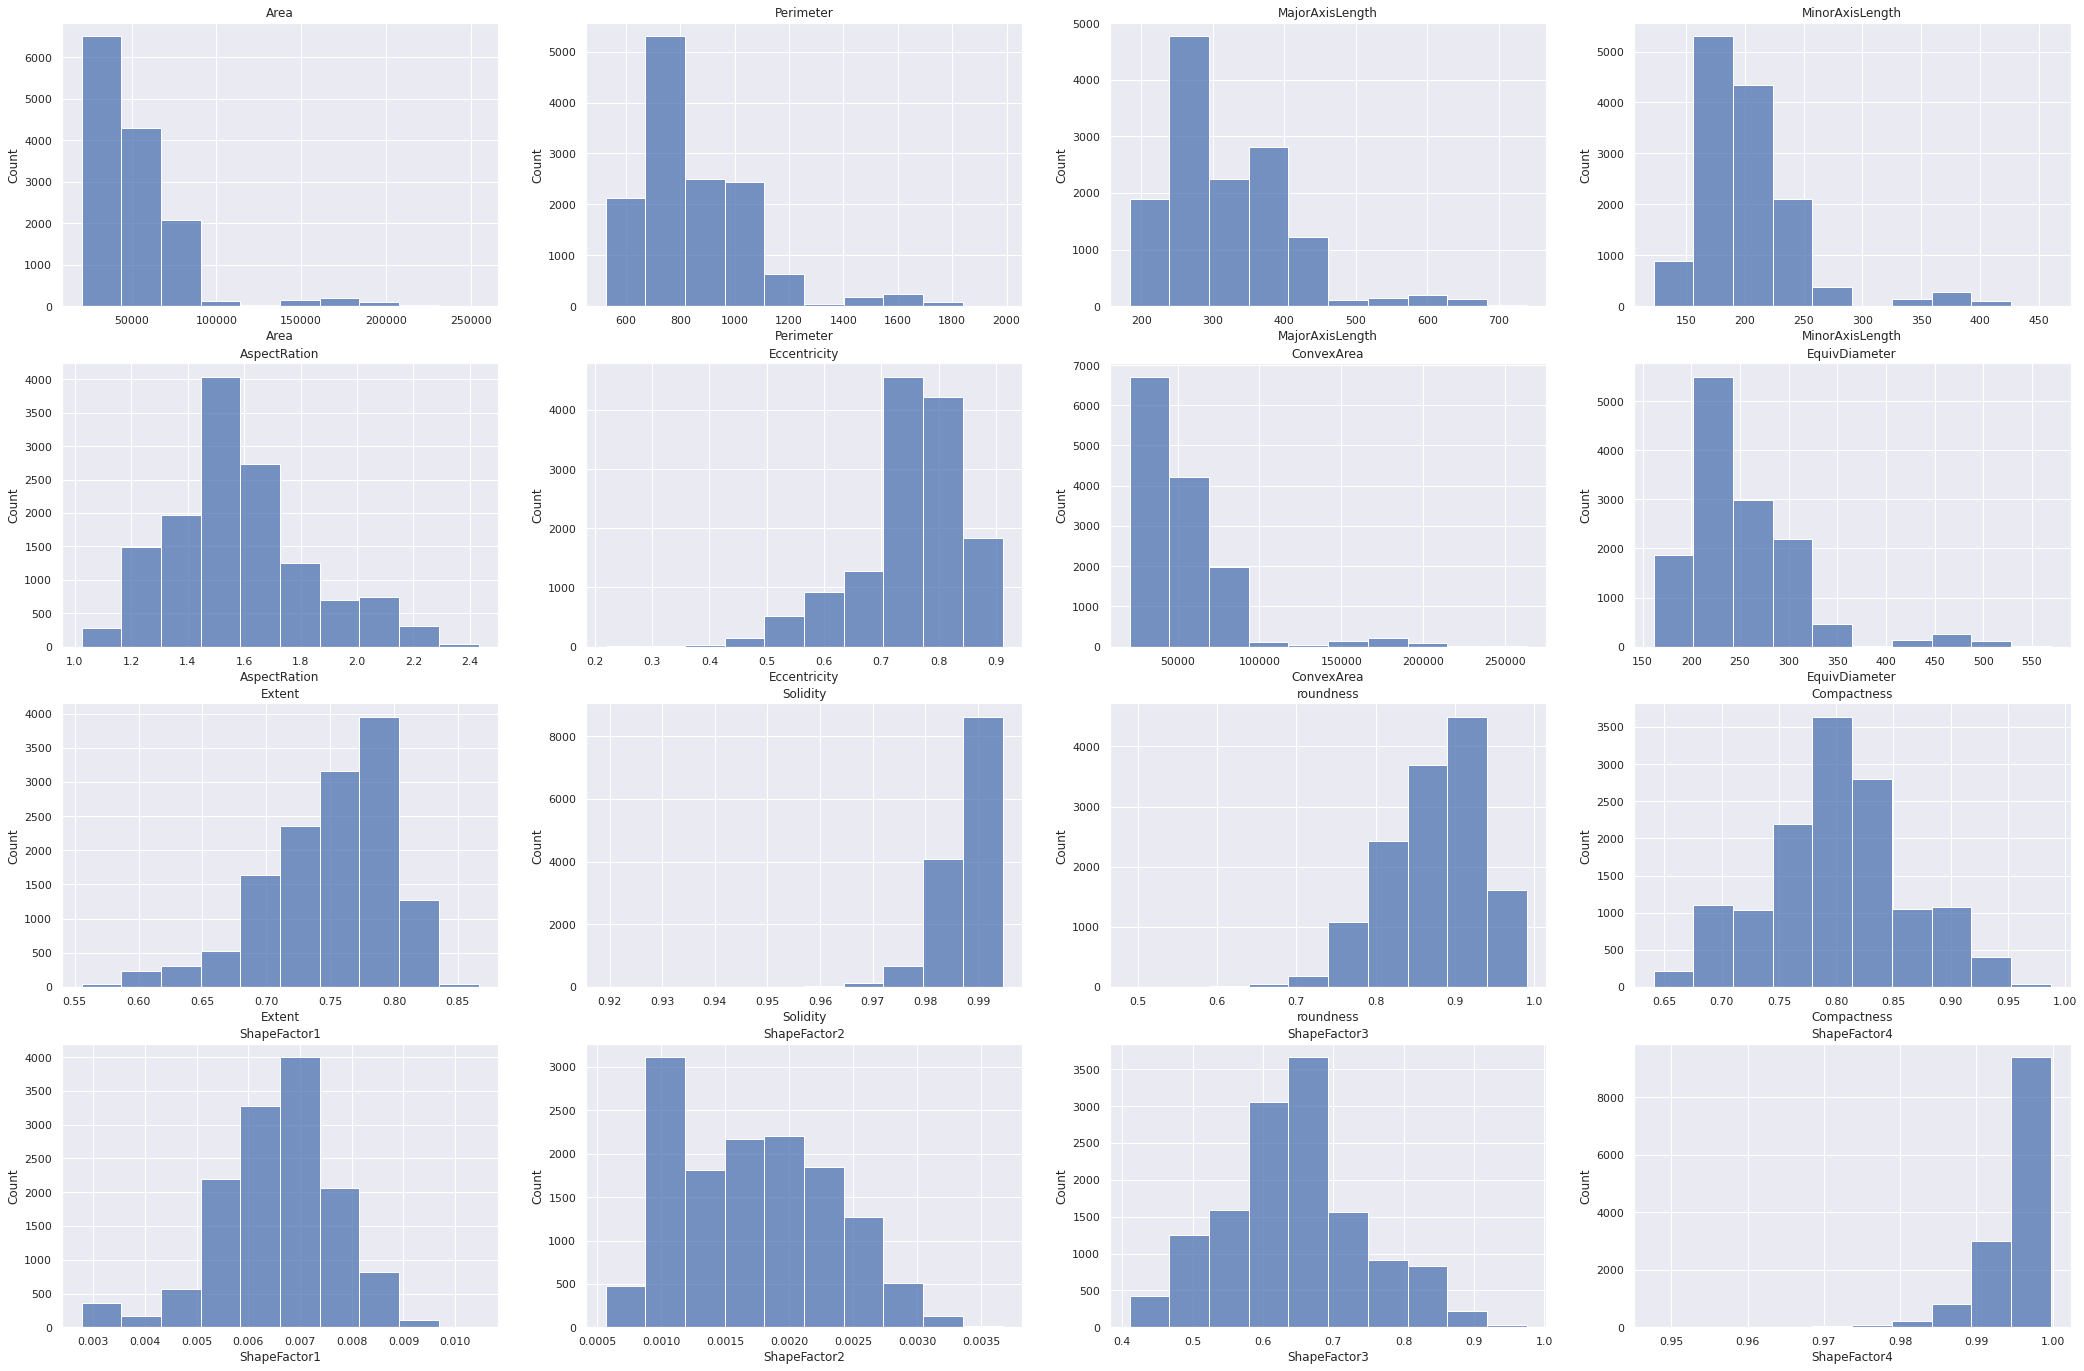

In [37]:
COLUMNS = df.columns.tolist()

feature_cols = COLUMNS[:-1]
sns.set(style='darkgrid')
fig, ax_list = plt.subplots(nrows=4, ncols=4, sharey=False, figsize=(36,24))
ax_list = ax_list.flatten()
for name, ax in zip(feature_cols, ax_list):
     g = sns.histplot(df, x=name, bins=10, ax=ax).set(title=name)

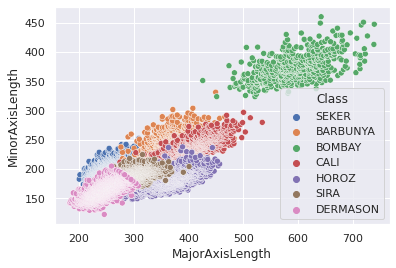

In [38]:
sns.scatterplot(x=df['MajorAxisLength'], y=df['MinorAxisLength'], hue=df['Class'])

In [39]:
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
#le = LabelEncoder()
#df['Class'] = le.fit_transform(df.Class)
#df['Class']

In [41]:
target = 'Class'

label = df[target]
features = df.drop([target], axis=1)

In [42]:
scaler = StandardScaler()
Z = scaler.fit_transform(features)

output = pd.DataFrame(Z, columns=features.columns, index=list(features.index.values))

In [43]:
pca = PCA(2)
df_pca= pca.fit_transform(output)
df_pca = pd.DataFrame(data = df_pca, columns=['PC1', 'PC2'])

In [44]:
df_pca['Class'] = label

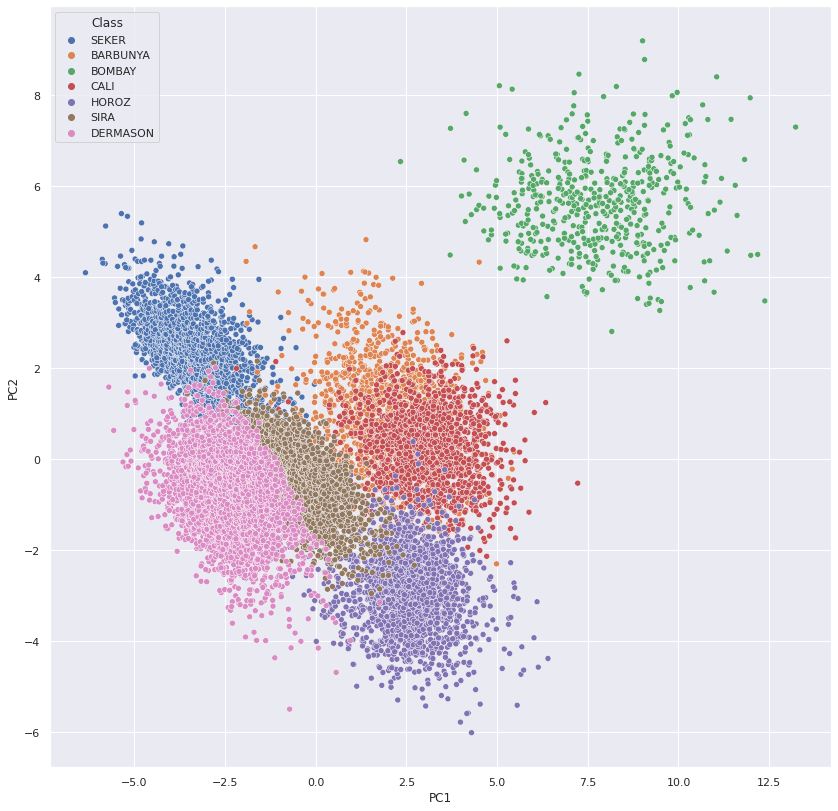

In [45]:
plt.figure(figsize=(14,14))
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca, hue = 'Class');

In [48]:
area = df['Area'].groupby(df['Class']).mean().sort_values()

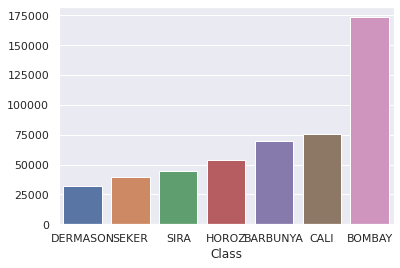

In [53]:
sns.barplot(x = area.index, y = area.values);

In [54]:
target = 'Class'

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((8667, 17), (2167, 17), (2709, 17))

In [55]:
train[target].value_counts(normalize=True)

DERMASON    0.261913
SIRA        0.194646
SEKER       0.149648
HOROZ       0.137302
CALI        0.120342
BARBUNYA    0.097612
BOMBAY      0.038537
Name: Class, dtype: float64

In [56]:
val[target].value_counts(normalize=True)

DERMASON    0.261652
SIRA        0.194739
SEKER       0.149515
HOROZ       0.137517
CALI        0.120443
BARBUNYA    0.097370
BOMBAY      0.038763
Name: Class, dtype: float64

In [57]:
test[target].value_counts(normalize=True)

DERMASON    0.261720
SIRA        0.194537
SEKER       0.149871
HOROZ       0.137320
CALI        0.120340
BARBUNYA    0.097822
BOMBAY      0.038391
Name: Class, dtype: float64

In [58]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [59]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

predict = dt_clf.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

F1 score: 0.8891375007155944


In [61]:
predict = dt_clf.predict(X_test)
f1=f1_score(y_test, predict, average='weighted')


print("F1 score: {}" .format(f1))

F1 score: 0.8959994964512971


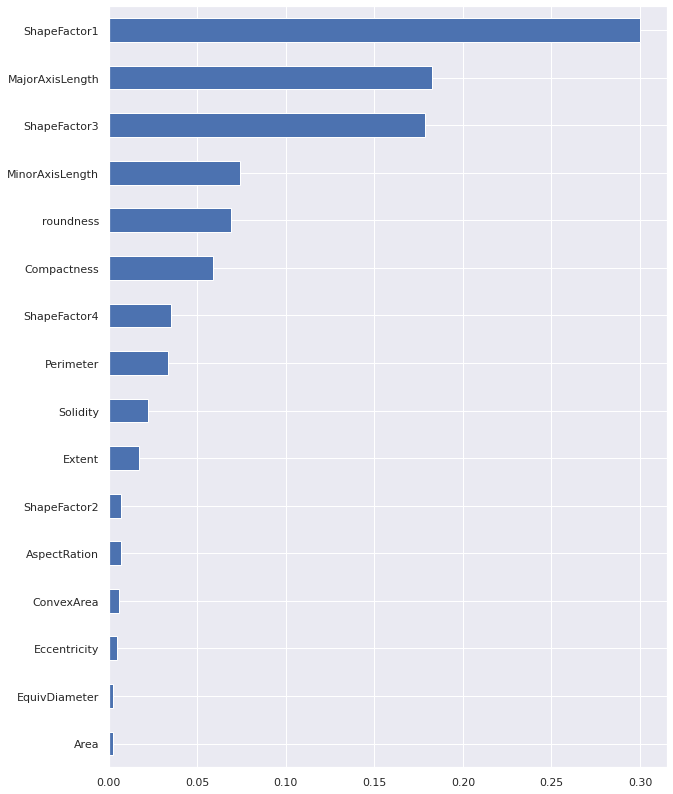

In [62]:
model_dt = dt_clf

importances = pd.Series(model_dt.feature_importances_, X_train.columns)
plt.figure(figsize=(10,14))
importances.sort_values().plot.barh();

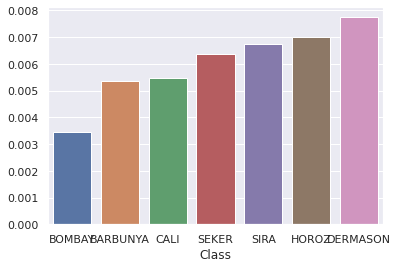

In [63]:
ft1 = train['ShapeFactor1'].groupby(df['Class']).mean().sort_values()

sns.barplot(x = ft1.index, y = ft1.values);

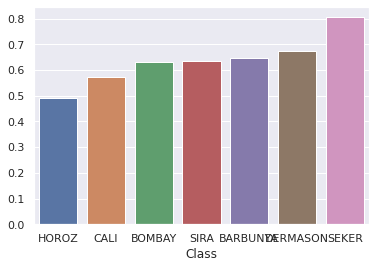

In [64]:
ft3 = train['ShapeFactor3'].groupby(df['Class']).mean().sort_values()

sns.barplot(x = ft3.index, y = ft3.values);

In [68]:
pipe = make_pipeline(
    RobustScaler(), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

params = {
    'randomforestclassifier__class_weight' : [None],
    'randomforestclassifier__max_depth' : [16],
    'randomforestclassifier__n_estimators' : [550],
    'randomforestclassifier__min_samples_leaf' : [4],
    'randomforestclassifier__max_features' : ['auto']
}

clf1 = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))


최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 550}
accuracy:  0.9208500969377263
검증 정확도 0.9584679280110752
F1 score: 0.958391035244608


In [ ]:
'''
최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 12,
                       'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 10, 
                       'randomforestclassifier__n_estimators': 300}
accuracy:  0.9184271529459684
검증 정확도 0.9358560221504384
F1 score: 0.9358783932572229
'''

In [ ]:
'''
최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 500}
accuracy:  0.9198118349882296
검증 정확도 0.946931241347485
F1 score: 0.946882781500124
'''

In [ ]:
# 최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 
#                        'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 
#                        'randomforestclassifier__n_estimators': 550}
# accuracy:  0.9208500969377263
# 검증 정확도 0.9584679280110752
# F1 score: 0.958391035244608


In [72]:
confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

ct

Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,193,0,0,0,2,1,1
BOMBAY,0,83,0,0,0,0,0
CALI,9,1,254,0,2,0,0
DERMASON,0,0,0,554,2,4,19
HOROZ,3,0,6,0,287,0,3
SEKER,1,0,1,5,0,312,5
SIRA,5,0,0,8,5,7,394


In [73]:
print(classification_report(predict, val['Class']))

              precision    recall  f1-score   support

    BARBUNYA       0.91      0.98      0.95       197
      BOMBAY       0.99      1.00      0.99        83
        CALI       0.97      0.95      0.96       266
    DERMASON       0.98      0.96      0.97       579
       HOROZ       0.96      0.96      0.96       299
       SEKER       0.96      0.96      0.96       324
        SIRA       0.93      0.94      0.94       419

    accuracy                           0.96      2167
   macro avg       0.96      0.96      0.96      2167
weighted avg       0.96      0.96      0.96      2167



In [79]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [76]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight('balanced', y_train)

In [85]:
X_train

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
7334,69452,1053.073,426.823196,210.749841,2.025260,0.869596,70718,297.370195,0.824307,0.982098,0.787005,0.696706,0.006146,0.000893,0.485399,0.983059
6574,54987,946.884,401.506883,176.323788,2.277100,0.898411,55691,264.597095,0.753825,0.987359,0.770684,0.659010,0.007302,0.000850,0.434294,0.988932
2571,67686,1044.470,368.601069,234.202503,1.573856,0.772198,69063,293.565141,0.708383,0.980062,0.779681,0.796431,0.005446,0.001352,0.634302,0.998299
258,34847,686.633,236.426224,188.062658,1.257167,0.606034,35229,210.638502,0.761018,0.989157,0.928808,0.890927,0.006785,0.002637,0.793751,0.997878
4520,72575,1045.603,412.245965,226.372175,1.821098,0.835744,73615,303.982499,0.784586,0.985872,0.834187,0.737381,0.005680,0.001036,0.543731,0.990188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,34509,668.332,230.329486,190.919741,1.206420,0.559399,34776,209.614464,0.783654,0.992322,0.970863,0.910064,0.006674,0.002824,0.828216,0.999176
7630,39028,733.184,272.167639,183.205367,1.485588,0.739520,39505,222.917009,0.766969,0.987926,0.912347,0.819043,0.006974,0.001936,0.670831,0.996579
4730,75297,1042.473,401.414812,240.355003,1.670091,0.800921,76241,309.630615,0.717729,0.987618,0.870679,0.771348,0.005331,0.001164,0.594978,0.993668
7798,40400,745.966,274.757788,187.568921,1.464836,0.730727,40832,226.801406,0.707469,0.989420,0.912333,0.825459,0.006801,0.001948,0.681383,0.998115


In [103]:
model = XGBClassifier(
    n_estimators=1000,  
    max_depth=12,        
    learning_rate=0.2,
    scale_pos_weight=classes_weights,
    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train), 
            (X_val_scaled, y_val)]

model.fit(X_train_scaled, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=30
         ) 

[0]	validation_0-mlogloss:1.36626	validation_1-mlogloss:1.39301
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 200 rounds.
[1]	validation_0-mlogloss:1.05788	validation_1-mlogloss:1.10572
[2]	validation_0-mlogloss:0.84784	validation_1-mlogloss:0.913119
[3]	validation_0-mlogloss:0.691133	validation_1-mlogloss:0.771623
[4]	validation_0-mlogloss:0.56999	validation_1-mlogloss:0.664705
[5]	validation_0-mlogloss:0.473878	validation_1-mlogloss:0.579489
[6]	validation_0-mlogloss:0.397424	validation_1-mlogloss:0.511732
[7]	validation_0-mlogloss:0.335649	validation_1-mlogloss:0.458636
[8]	validation_0-mlogloss:0.284638	validation_1-mlogloss:0.416574
[9]	validation_0-mlogloss:0.242954	validation_1-mlogloss:0.381806
[10]	validation_0-mlogloss:0.20854	validation_1-mlogloss:0.353509
[11]	validation_0-mlogloss:0.179744	validation_1-mlogloss:0.330191
[12]	validation_0-mlogloss:0.156022	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1,
              scale_pos_weight=array([1.04045618, 1.04045618, 1.46352584, ..., 1.18709766, 0.73393175,
       0.95462055]),
              seed=None, silent=None, subsample=1, verbosity=1)

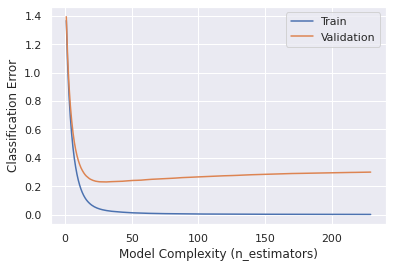

In [104]:
results = model.evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

In [105]:
print('검증 정확도', model.score(X_val_scaled, y_val))

print(classification_report(y_val, model.predict(X_val_scaled)))

검증 정확도 0.9229349330872173
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.93      0.93       211
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.95      0.95      0.95       261
    DERMASON       0.92      0.91      0.92       567
       HOROZ       0.97      0.94      0.95       298
       SEKER       0.93      0.92      0.92       324
        SIRA       0.86      0.89      0.87       422

    accuracy                           0.92      2167
   macro avg       0.94      0.94      0.94      2167
weighted avg       0.92      0.92      0.92      2167



In [97]:
predict = model.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))

F1 score: 0.9240840971187069


In [100]:
confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

print(classification_report(predict, val['Class']))

ct

              precision    recall  f1-score   support

    BARBUNYA       0.91      0.94      0.92       205
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.95      0.95      0.95       263
    DERMASON       0.92      0.92      0.92       571
       HOROZ       0.94      0.97      0.95       291
       SEKER       0.93      0.95      0.94       318
        SIRA       0.88      0.86      0.87       435

    accuracy                           0.92      2167
   macro avg       0.93      0.94      0.94      2167
weighted avg       0.92      0.92      0.92      2167



Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,192,0,6,0,3,2,2
BOMBAY,0,84,0,0,0,0,0
CALI,11,0,249,0,3,0,0
DERMASON,0,0,0,523,3,4,41
HOROZ,2,0,5,1,281,0,2
SEKER,1,0,1,10,0,301,5
SIRA,5,0,0,33,8,17,372
